ADF Statistic: -1.7177091486133373
p-valor: 0.42201206191181045
La serie no es estacionaria. Se recomienda diferenciar.
Orden de diferenciación aplicado: 1
Mejor modelo ARIMA(0, 1, 1) con AIC: 433.6565090059378


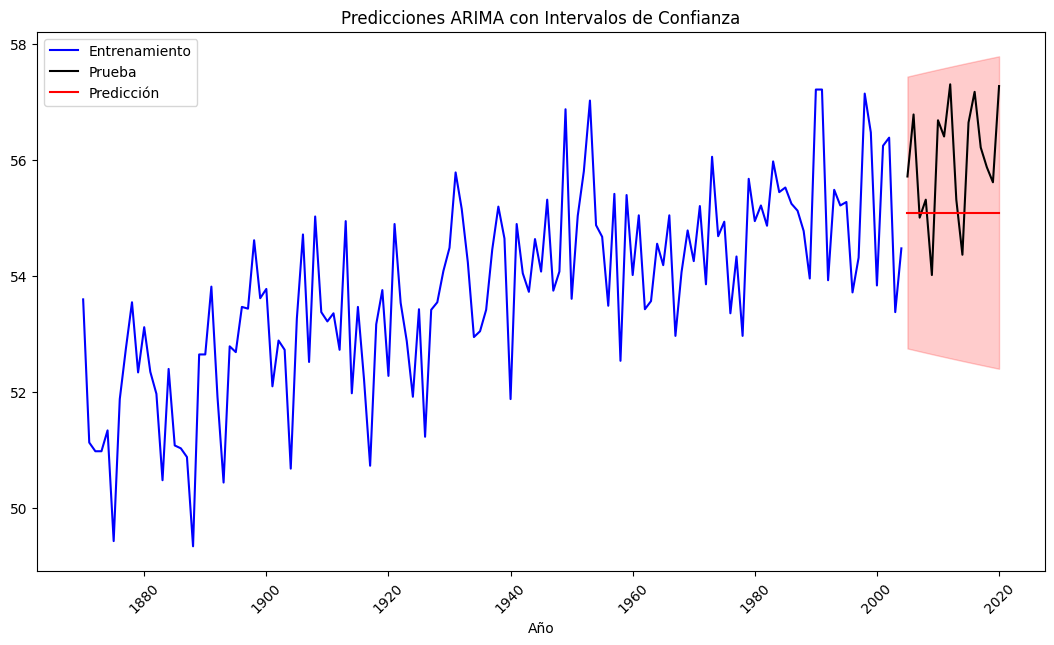

RMSE: 1.3190394053674683, MAE: 1.125482492238258, MAPE: 1.9941485316351888%
El modelo tiene una alta precisión.


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings

warnings.filterwarnings('ignore')



# Cargar datos
df = pd.read_csv("TempNY.csv", index_col="Year")
df = df.drop(['Unnamed: 2'], axis = 1)


# Dividir en entrenamiento (90%) y prueba (10%)
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]




# Prueba de Dickey-Fuller para estacionariedad
def test_stationarity(series):
    
    result = adfuller(series)
    
    print(f"ADF Statistic: {result[0]}")
    print(f"p-valor: {result[1]}")
    
    if result[1] > 0.05:
        print("La serie no es estacionaria. Se recomienda diferenciar.")
    else:
        print("La serie es estacionaria.")

test_stationarity(train["Average"])




# Aplicar diferencias hasta obtener estacionariedad
d = 1  # Comenzar con al menos una diferenciación
while d < len(train) and adfuller(train["Average"].diff(d).dropna())[1] > 0.05:
    d += 1

print(f"Orden de diferenciación aplicado: {d}")




# Selección de parámetros óptimos con AIC
p_vals = range(0, 3)
q_vals = range(0, 3)
combinations = list(product(p_vals, q_vals))

best_aic = np.inf
best_params = None

for p, q in combinations:
    try:
        model = ARIMA(train["Average"], order=(p, d, q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = (p, d, q)
    except:
        continue

print(f"Mejor modelo ARIMA{best_params} con AIC: {best_aic}")





# Entrenar modelo óptimo
p, d, q = best_params
model = ARIMA(train["Average"], order=(p, d, q)).fit()



# Predicciones
pred = model.forecast(steps=len(test))
pred = pd.DataFrame(pred)
pred.index =  test.index
intervals = model.get_forecast(steps=len(test)).conf_int()



# Gráfica de resultados
plt.figure(figsize=(13, 7))
plt.plot(train.index, train["Average"], label="Entrenamiento", color="blue")
plt.plot(test.index, test["Average"], label="Prueba", color="black")
plt.plot(test.index, pred, label="Predicción", color="red")
plt.fill_between(test.index, intervals.iloc[:,0], intervals.iloc[:,1], color="red", alpha=0.2)

plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mayor claridad
plt.xlabel("Año")  # Agregar título al eje X

plt.legend()
plt.title("Predicciones ARIMA con Intervalos de Confianza")
plt.show()



# Evaluación del modelo con métricas de error
rmse = np.sqrt(np.mean((test["Average"] - pred['predicted_mean'])**2))
mae = np.mean(np.abs(test["Average"] - pred['predicted_mean']))
mape = np.mean(np.abs((test["Average"] - pred['predicted_mean']) / test["Average"])) * 100

print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")




# Evaluación de confiabilidad del modelo
if mape < 10:
    print("El modelo tiene una alta precisión.")
elif mape < 20:
    print("El modelo tiene una precisión aceptable.")
else:
    print("El modelo no es confiable para pronósticos precisos.")

